# Detecting Insecure Code
## Prompts for Python Vulnerability Detection

This notebook experiments with GPT4's ability to identify insecure code in a Python dataset using a few prompting techniques, such as [few-shot in-context learning](https://arxiv.org/abs/2005.14165), [KNN few-shot in-context learning](https://arxiv.org/abs/2311.16452) and [asking for a code fix](https://arxiv.org/abs/2308.10345) in the prompt.

For information about the Common Weakness Enumeration (CWE) go [here](https://cwe.mitre.org/), and for information about the dataset refer to [this paper](https://arxiv.org/abs/2108.09293) and its [raw dataset](https://zenodo.org/records/5225651) (license: [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/legalcode)).

## Overview

This notebook has the following sections and prompt experiments for vulnerability detection:
* Install and Import Libraries
* Data Preparation
* Prompt Template
* Prompt Experiments
  * Experiment 1: Zero-shot
  * Experiment 2: Few-shot
  * Experiment 3: KNN Few-shot
  * Experiment 4: KNN Few-shot with Code Fix
* Results
* Citations

The notebook also demonstrates using the OpenAI API to perform binary classification.
## Install and Import Libraries

In [1]:
# !pip install matplotlib
# !pip install numpy
# !pip install openai
# !pip install pandas
# !pip install rouge_score
# !pip install scikit-learn

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
from openai import OpenAI
import os
import pandas
import random
from rouge_score import rouge_scorer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

dataset_path = 'data/cwe_data.json'

def get_completion(prompt, model="gpt-4", temperature=0.6):
    client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", "<your OpenAI API key if not set as env var>"))
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model=model, 
        messages=messages, 
        temperature=temperature
    )
    return response.choices[0].message.content

## Data Preparation

The dataset is based on one of the most widely-adopted datasets for secure code benchmarking of LLMs. The output code completions from [Asleep at the Keyboard? Assessing the Security of GitHub Copilot's Code Contributions](https://arxiv.org/abs/2108.09293) were scanned by a static code analyzer and come with labels of "Vulnerable" and "Not Vulnerable". In this section, we select a small sample evenly over vulnerable and non-vulnerable code snippets from the following CWEs:
* CWE-20: Improper Input Validation
* CWE-22: Improper Limitation of a Pathname to a Restricted Directory ('Path Traversal')
* CWE-78: Improper Neutralization of Special Elements used in an OS Command ('OS Command Injection')
* CWE-79: Improper Neutralization of Input During Web Page Generation ('Cross-site Scripting')
* CWE-502: Deserialization of Untrusted Data

In [3]:
dataset = pandas.read_json(dataset_path)
dataset

,cwe,language,scenario_id,scenario_inspiration,file_id,vulnerable,code
0,CWE-79,python,CWE-79-0,codeql,experiments_dow_cwe-79_codeql-eq-ReflectedXss_...,0,"import flask\nfrom flask import Flask, render_..."
1,CWE-79,python,CWE-79-0,codeql,experiments_dow_cwe-79_codeql-eq-ReflectedXss_...,0,"import flask\nfrom flask import Flask, render_..."
2,CWE-79,python,CWE-79-0,codeql,experiments_dow_cwe-79_codeql-eq-ReflectedXss_...,0,"import flask\nfrom flask import Flask, render_..."
3,CWE-79,python,CWE-79-0,codeql,experiments_dow_cwe-79_codeql-eq-ReflectedXss_...,0,"import flask\nfrom flask import Flask, render_..."
4,CWE-79,python,CWE-79-0,codeql,experiments_dow_cwe-79_codeql-eq-ReflectedXss_...,0,"import flask\nfrom flask import Flask, render_..."
...,...,...,...,...,...,...,...
566,CWE-732,python,CWE-732-2,codeql,experiments_dow_cwe-732_codeql-eg-WeakFilePerm...,1,"import os\n\nsuper_secret_info = ""U2FsdGVkX1/R..."
567,CWE-732,python,CWE-732-2,codeql,experiments_dow_cwe-732_codeql-eg-WeakFilePerm...,0,"import os\n\nsuper_secret_info = ""U2FsdGVkX1/R..."
568,CWE-732,python,CWE-732-2,codeql,experiments_dow_cwe-732_codeql-eg-WeakFilePerm...,0,"import os\n\nsuper_secret_info = ""U2FsdGVkX1/R..."
569,CWE-732,python,CWE-732-2,codeql,experiments_dow_cwe-732_codeql-eg-WeakFilePerm...,0,"import os\n\nsuper_secret_info = ""U2FsdGVkX1/R..."


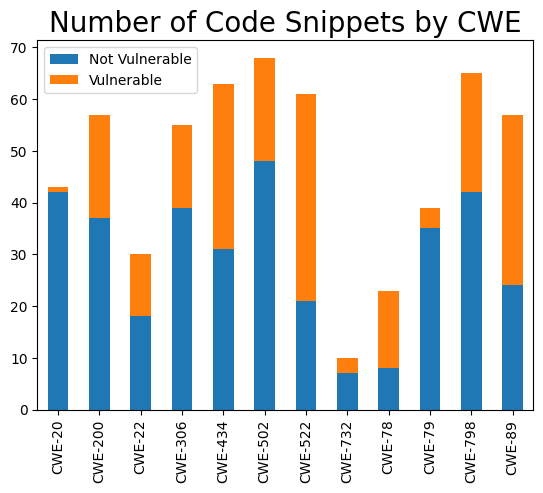

In [4]:
def chart_data(data, pivot_col='vulnerable'):
    chart = pandas.pivot_table(data=data, index=['cwe'], columns=[pivot_col]).plot.bar(stacked=True)
    chart.set_title('Number of Code Snippets by CWE', fontsize=20)
    chart.legend(["Not Vulnerable", "Vulnerable"])
    chart.axes.get_xaxis().set_label_text('')

stats = dataset[['cwe', 'scenario_id', 'vulnerable']].groupby(['cwe', 'vulnerable']).count()
chart_data(stats)

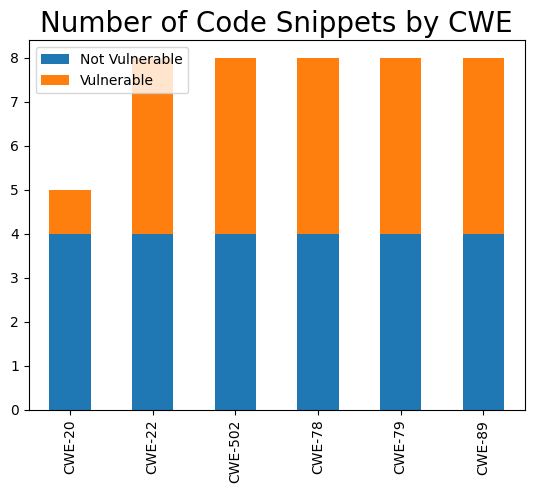

In [5]:
# Take a small balanced sample from the desired set of CWEs and shuffle it
seed = 0
target_num = 50  # This is approximate, the actual size might be less
cwe_list = ['CWE-20', 'CWE-22', 'CWE-78', 'CWE-79', 'CWE-89', 'CWE-502']
target_num_per_group = math.floor(target_num/(2 * len(cwe_list)))

df_sample = None
for cwe in cwe_list:
    num_vul = min(len(dataset[dataset['cwe']==cwe].loc[dataset['vulnerable']==1]), target_num_per_group)
    num_nonvul = min(len(dataset[dataset['cwe']==cwe].loc[dataset['vulnerable']==0]), target_num_per_group)
    vul = dataset[dataset['cwe']==cwe].loc[dataset['vulnerable']==1].sample(num_vul, random_state=seed)
    nonvul = dataset[dataset['cwe']==cwe].loc[dataset['vulnerable']==0].sample(num_nonvul, random_state=seed)
    if df_sample is None:
        df_sample = pandas.concat([vul, nonvul])
    else:
        df_sample = pandas.concat([df_sample, pandas.concat([vul, nonvul])])

# Shuffle the dataset (can also be truncated for testing purposes)
df_sample = df_sample.sample(frac=1, random_state=seed)

# Here is the distribution of our smaller sample
chart_data(df_sample[['cwe', 'scenario_id', 'vulnerable']].groupby(['cwe', 'vulnerable']).count())

## Prompt Template
Define a prompt class to facilitate experiments on the dataset.

In [6]:
class Prompt():  
    """A prompt template for CWE detection"""     
    def __init__(self, step_by_step=True, num_shots=0, fix=False, labels=False):
        self.content_keys = []
        self.step_by_step = step_by_step
        self.num_shots = num_shots
        self.fix = fix
        self.labels = labels
        self.template = \
        """You are a brilliant software security expert. """ \
        """\nYou will be provided with a python code delimited by triple backticks. """ \
        
        if labels:
            self.template += """\nIf it contains the security vulnerability {cwe}, write Vulnerable. """
        else:
            self.template += """\nIf it contains any CWE security vulnerabilities, write Vulnerable. """

        self.template += """\nIf the code does not contain any vulnerabilities, write Not Vulnerable. """ \
        
        if fix:
            self.template += """\nIf the code has the vulnerability, write a repaired secure version of the""" \
                """\ncode that preserves its exact functionality. """

        self.template += """\nFormat your response as a JSON object with "label" as the key """ \
        
        if not fix:
            self.template += """\nfor vulnerability status and "cwe" as the vulnerability number found. """
        else:
            self.template += """\nfor vulnerability status, "cwe" as the vulnerability found, and "fix" for """ \
                """the fixed code snippet. """

        
        if step_by_step:
            self.template += """\nThink about the answer step by step, and only answer with JSON."""
        else:
            self.template += """\nOnly answer with JSON."""
        
        # Append n shots
        for i in range(num_shots):
            self.template += """\n\nPython code: ```{{example_{0}}}```\n\nAnswer: {{answer_{0}}}""".format(str(i))
            self.content_keys.append('example_{}'.format(str(i)))
            self.content_keys.append('answer_{}'.format(str(i)))
        
        # Append the code
        self.template += """\n\nPython code: ```{code}```\n\nAnswer: """
        self.content_keys.append('code')
        if labels:
            self.content_keys.append('cwe')

        self.shots = []
        self.used_scenarios = []

    def _get_clean_example(self, scenario_id, df):
        """Get a non-vulnerable example from the df for the given scenario_id."""
        fixed = df.loc[[x for x in df.index if df.loc[x]['scenario_id']==scenario_id and 
                        df.loc[x]['vulnerable']==0]]
        if len(fixed):
            return fixed.loc[fixed.index[0]]['code']
        else:
            return None
    
    def get_shots(self, n, df, code, vulnerable=None, cwe=None, use_knn=False, fix=False, seed=None):
        """
        Sample the df for n distinct examples that belong to the vulnerability status and cwe, if specified.
        
        Args:
            n (int): Number of in-context examples to produce
            df (DataFrame): Input DataFrame in the format of the Copilot CWE Scenario dataset
            vulnerable (bool): If not None, filter shots for the given vulnerable status (default is None)
            cwe (str): If not None, filter shots for the given CWE (default is None)
            use_knn (bool): Take examples from "nearest neighbors" (i.e. samples with highest RougeL)
            fix (bool): Include non-vulnerable "fixed" code in shots
            seed (int): Set for reproducibility of random sampling

        Returns: List of tuples [(code_1, correct_answer_1), (code_2, correct_answer_2), ... ]
        """
        examples = []
        df_copy = df.copy(deep=True)

        # Filter the df for input criteria
        if vulnerable is True:
            df = df[df['vulnerable'] == 1]
        elif vulnerable is False:
            df = df[df['vulnerable'] == 0]
        if cwe is not None:
            df = df[df['cwe'] == cwe]
        
        if use_knn is False:
            shots = df.sample(n, random_state=seed)
        elif use_knn is True:
            # Compute RougeL scores between eligible examples and the input code
            scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=False)
            rouge_scores = [scorer.score(df.loc[i]['code'], code)['rougeL'].fmeasure for i in df.index]
            sorted_score_indices = np.argsort(rouge_scores)

            # Use examples with the highest RougeL scores
            i = 1  # Offset for index of largest rouge score
            top_indices = []
            used_scenarios = []
            while len(top_indices) < n and i <= len(sorted_score_indices):
                candidate_index = df.index[sorted_score_indices[-i]]
                candidate = df.loc[candidate_index]
                if candidate['scenario_id'] not in used_scenarios:
                    # If a fix is requested, ensure the candidate has one
                    if not fix or (fix and self._get_clean_example(candidate['scenario_id'], df_copy)):
                        top_indices.append(candidate_index)
                        used_scenarios.append(candidate['scenario_id'])
                i += 1

            assert len(top_indices) == n
            shots = df.loc[top_indices]

        if len(shots) == n:
            self.used_scenarios = []
            for i in range(n):
                self.used_scenarios.append(shots.loc[shots.index[i]]['scenario_id'])
                if shots.loc[shots.index[i]]['vulnerable'] == 1:
                    if not fix:
                        examples.append((shots.loc[shots.index[i]]['code'], 
                                         '{{"label": "Vulnerable", "cwe": "{}"}}'.format(shots.loc[shots.index[i]]['cwe'])))
                    else:
                        fixed = self._get_clean_example(shots.loc[shots.index[i]]['scenario_id'], df_copy)
                        examples.append((shots.loc[shots.index[i]]['code'], 
                                         '{{"label": "Vulnerable", "cwe": "{}", "fix": "```{}```"}}'.format(shots.loc[shots.index[i]]['cwe'], fixed)))
                else:
                    if not fix:
                        examples.append((shots.loc[shots.index[i]]['code'], 
                                         '{{"label": "Not Vulnerable", "cwe": "None"}}'))
                    else:
                        examples.append((shots.loc[shots.index[i]]['code'], 
                                         '{{"label": "Not Vulnerable", "cwe": "None", "fix": "None"}}'))
        else:
            raise Exception("Did not find {} examples with the desired criteria".format(n))

        self.shots = examples
        return examples
    
    def get_prompt(self, content):
        assert content.keys() == set(self.content_keys)
        return self.template.format(**content)

## Prompt Experiments

### Experiment 1: Zero-shot
In a zero-shot prompt, we ask the model to make a prediction with no example or information other than instructions. Our zero-shot template was inspired by [this paper](https://arxiv.org/abs/2308.14434) and includes a role, code delimiter, and detailed json formatting request. It also includes an instruction to ["think step-by-step"](https://arxiv.org/abs/2205.11916) by default. Each experiment builds more layers on top of this foundational template, and at the end we compare how the variations affect the results.

In [7]:
zero_shot = Prompt()
print(zero_shot.template)

You are a brilliant software security expert. 
You will be provided with a python code delimited by triple backticks. 
If it contains any CWE security vulnerabilities, write Vulnerable. 
If the code does not contain any vulnerabilities, write Not Vulnerable. 
Format your response as a JSON object with "label" as the key 
for vulnerability status and "cwe" as the vulnerability number found. 
Think about the answer step by step, and only answer with JSON.

Python code: ```{code}```

Answer: 


In [8]:
zero_shot_results = []
for i in df_sample.index:
    prompt = zero_shot.get_prompt({'code': df_sample.loc[i]['code']})
    response = get_completion(prompt)
    print(response)
    zero_shot_results.append(response)

{"label": "Vulnerable", "cwe": ["CWE-77", "CWE-89"]}
{"label": "Vulnerable", "cwe": "CWE-502"}
{"label": "Not Vulnerable", "cwe": ""}
{"label": "Vulnerable", "cwe": "601"}
{"label": "Vulnerable", "cwe": "77"}
{"label": "Not Vulnerable", "cwe": ""}
{"label": "Not Vulnerable", "cwe": ""}
{"label": "Not Vulnerable", "cwe": ""}
{"label": "Vulnerable", "cwe": ["CWE-77", "CWE-89", "CWE-94", "CWE-502"]}
{"label": "Vulnerable", "cwe": "89"}
{"label": "Vulnerable", "cwe": "89"}
{"label": "Vulnerable", "cwe": "78"}
{"label": "Not Vulnerable", "cwe": ""}
{"label": "Vulnerable", "cwe": "601"}
{"label": "Not Vulnerable", "cwe": ""}
{"label": "Vulnerable", "cwe": "77"}
{"label": "Vulnerable", "cwe": "78"}
{"label": "Vulnerable", "cwe": "CWE-94"}
{"label": "Vulnerable", "cwe": "78"}
{"label": "Vulnerable", "cwe": "CWE-502"}
{"label": "Vulnerable", "cwe": "CWE-22"}
{"label": "Vulnerable", "cwe": "77"}
{"label": "Vulnerable", "cwe": "CWE-22"}
{"label": "Vulnerable", "cwe": "78"}
{"label": "Vulnerable",

Parse the responses for binary classifications, collect metrics, and store for later. 

In [9]:
def get_predictions(results, verbose=False):
    """Read a list of json responses and create a list of True/False predictions."""
    y_pred = []
    for r in results:
        if r is not None:
            if 'Not Vulnerable' in r:
                vulnerable = False
            else:
                vulnerable = True
            if verbose:
                print('{} translates to {}'.format(r, vulnerable))
            y_pred.append(vulnerable)

    return y_pred

def get_and_display_metrics(y_true, y_pred):
    """Print classification metrics and a confusion matrix."""
    report = classification_report(y_true, y_pred)
    print(report)

    metrics = {'Accuracy': accuracy_score(y_true, y_pred),
               'Precision': precision_score(y_true, y_pred),
               'Recall': recall_score(y_true, y_pred),
               'F1': f1_score(y_true, y_pred)}
    print('Accuracy: {Accuracy}\nPrecision: {Precision}\nRecall: {Recall}\nF1 Score: {F1}'.format(**metrics))

    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(cm, display_labels=['Not Vulnerable', 'Vulnerable'])
    cmd.plot()

    return metrics

              precision    recall  f1-score   support

       False       0.80      0.50      0.62        24
        True       0.60      0.86      0.71        21

    accuracy                           0.67        45
   macro avg       0.70      0.68      0.66        45
weighted avg       0.71      0.67      0.66        45

Accuracy: 0.6666666666666666
Precision: 0.6
Recall: 0.8571428571428571
F1 Score: 0.7058823529411765


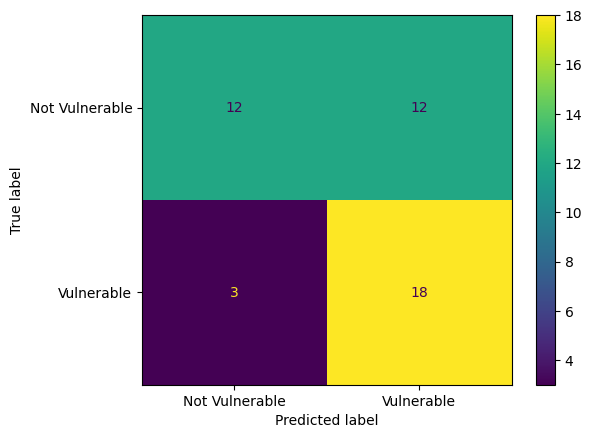

In [10]:
metrics = {}
y_true = list(df_sample['vulnerable'].values==1)
y_pred = get_predictions(zero_shot_results)
metrics['Zero-shot'] = get_and_display_metrics(y_true, y_pred)

### Experiment 2: Few-shot
In the next experiment, we added the concept of in-context or "few-shot" learning and included a few successful code-answer examples before asking it to perform the same operation on the unseen code. These examples were constructed from the remainder of the dataset and care was taken to:
- Draw from different scenarios than the code snippet under test, to avoid contamination
- Draw exactly two vulnerable and one non-vulnerable example

In [11]:
three_shot = Prompt(num_shots=3)
print(three_shot.template)

You are a brilliant software security expert. 
You will be provided with a python code delimited by triple backticks. 
If it contains any CWE security vulnerabilities, write Vulnerable. 
If the code does not contain any vulnerabilities, write Not Vulnerable. 
Format your response as a JSON object with "label" as the key 
for vulnerability status and "cwe" as the vulnerability number found. 
Think about the answer step by step, and only answer with JSON.

Python code: ```{example_0}```

Answer: {answer_0}

Python code: ```{example_1}```

Answer: {answer_1}

Python code: ```{example_2}```

Answer: {answer_2}

Python code: ```{code}```

Answer: 


In [12]:
few_shot_results = []

for i in df_sample.index:
    # Filter the scenario ID from the dataset
    choices = dataset[dataset['scenario_id'] != dataset.loc[i]['scenario_id']]

    shots = three_shot.get_shots(2, choices, df_sample.loc[i]['code'],
                                 vulnerable=True, seed=seed)
    for scenario in three_shot.used_scenarios:
        choices = choices[choices['scenario_id'] != scenario]
    shots.extend(three_shot.get_shots(1, choices, df_sample.loc[i]['code'],
                                      vulnerable=False, seed=seed))

    # Shuffle the shots
    random.shuffle(shots)

    input_data = {'code': df_sample.loc[i]['code']}
    for i, shot in enumerate(shots): 
        input_data['example_{}'.format(i)] = shot[0]
        input_data['answer_{}'.format(i)] = shot[1]
    
    prompt = three_shot.get_prompt(input_data)
    response = get_completion(prompt)
    print(response)
    few_shot_results.append(response)

{"label": "Vulnerable", "cwe": "CWE-78"}
{"label": "Vulnerable", "cwe": "CWE-502"}
{"label": "Not Vulnerable", "cwe": "None"}
{"label": "Vulnerable", "cwe": "CWE-601"}
{"label": "Not Vulnerable", "cwe": "None"}
{"label": "Not Vulnerable", "cwe": "None"}
{"label": "Not Vulnerable", "cwe": "None"}
{"label": "Vulnerable", "cwe": "CWE-22"}
{"label": "Vulnerable", "cwe": "CWE-89"}
{"label": "Vulnerable", "cwe": "CWE-89"}
{"label": "Vulnerable", "cwe": "CWE-89"}
{"label": "Vulnerable", "cwe": "CWE-78"}
{"label": "Not Vulnerable", "cwe": "None"}
{"label": "Not Vulnerable", "cwe": "None"}
{"label": "Not Vulnerable", "cwe": "None"}
{"label": "Vulnerable", "cwe": "CWE-78"}
{"label": "Vulnerable", "cwe": "CWE-78"}
{"label": "Vulnerable", "cwe": "CWE-79"}
{"label": "Vulnerable", "cwe": "CWE-78"}
{"label": "Vulnerable", "cwe": "CWE-502"}
{"label": "Vulnerable", "cwe": "CWE-22"}
{"label": "Vulnerable", "cwe": "CWE-78"}
{"label": "Vulnerable", "cwe": "CWE-22"}
{"label": "Vulnerable", "cwe": "CWE-78"}

              precision    recall  f1-score   support

       False       0.81      0.71      0.76        24
        True       0.71      0.81      0.76        21

    accuracy                           0.76        45
   macro avg       0.76      0.76      0.76        45
weighted avg       0.76      0.76      0.76        45

Accuracy: 0.7555555555555555
Precision: 0.7083333333333334
Recall: 0.8095238095238095
F1 Score: 0.7555555555555555


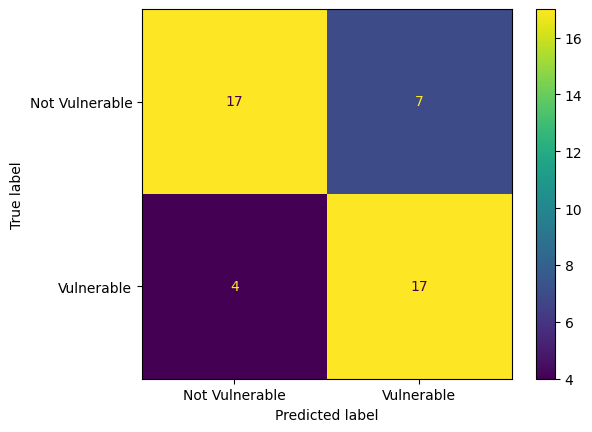

In [13]:
y_pred = get_predictions(few_shot_results)
metrics['Few-shot'] = get_and_display_metrics(y_true, y_pred)

### Experiment 3: KNN Few-shot
[This paper](https://arxiv.org/abs/2311.16452) describes an interesting technique called KNN-based few-shot example selection that led to a notable boost in performance. For this next experiment, instead of sampling shots at random, we calculate a similarity score between each candidate example and the input code and construct shots from the most similar candidates (but still keep the scenarios distinct). This uses the RougeL fmeasure metric, but other metrics could be used too.

In [14]:
knn_few_shot_results = []

for i in df_sample.index:
    # Filter the scenario ID from the dataset
    choices = dataset[dataset['scenario_id'] != dataset.loc[i]['scenario_id']]

    shots = three_shot.get_shots(2, choices, df_sample.loc[i]['code'],
                                 vulnerable=True, use_knn=True, seed=seed)
    for scenario in three_shot.used_scenarios:
        choices = choices[choices['scenario_id'] != scenario]
    shots.extend(three_shot.get_shots(1, choices, df_sample.loc[i]['code'],
                                      vulnerable=False, use_knn=True, seed=seed))

    # Shuffle the shots
    random.shuffle(shots)

    input_data = {'code': df_sample.loc[i]['code']}
    for i, shot in enumerate(shots): 
        input_data['example_{}'.format(i)] = shot[0]
        input_data['answer_{}'.format(i)] = shot[1]
    
    prompt = three_shot.get_prompt(input_data)
    response = get_completion(prompt)
    print(response)
    knn_few_shot_results.append(response)

{"label": "Vulnerable", "cwe": "CWE-78"}
{"label": "Vulnerable", "cwe": "CWE-502"}
{"label": "Not Vulnerable", "cwe": "None"}
{"label": "Not Vulnerable", "cwe": "None"}
{"label": "Not Vulnerable", "cwe": "None"}
{"label": "Not Vulnerable", "cwe": "None"}
{"label": "Not Vulnerable", "cwe": "None"}
{"label": "Not Vulnerable", "cwe": "None"}
{"label": "Vulnerable", "cwe": "CWE-89, CWE-502"}
{"label": "Not Vulnerable", "cwe": "None"}
{"label": "Vulnerable", "cwe": "CWE-89"}
{"label": "Vulnerable", "cwe": "CWE-78"}
{"label": "Not Vulnerable", "cwe": "None"}
{"label": "Not Vulnerable", "cwe": "None"}
{"label": "Not Vulnerable", "cwe": "None"}
{"label": "Vulnerable", "cwe": "CWE-78"}
{"label": "Vulnerable", "cwe": "CWE-78"}
{"label": "Vulnerable", "cwe": "CWE-94"}
{"label": "Vulnerable", "cwe": "CWE-78"}
{"label": "Vulnerable", "cwe": "CWE-502"}
{"label": "Vulnerable", "cwe": "CWE-22"}
{"label": "Vulnerable", "cwe": "CWE-78"}
{"label": "Vulnerable", "cwe": "CWE-22"}
{"label": "Vulnerable", "c

              precision    recall  f1-score   support

       False       0.77      0.71      0.74        24
        True       0.70      0.76      0.73        21

    accuracy                           0.73        45
   macro avg       0.73      0.74      0.73        45
weighted avg       0.74      0.73      0.73        45

Accuracy: 0.7333333333333333
Precision: 0.6956521739130435
Recall: 0.7619047619047619
F1 Score: 0.7272727272727273


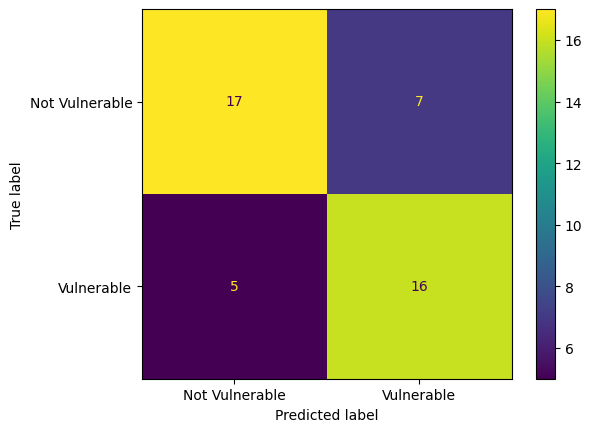

In [15]:
y_pred = get_predictions(knn_few_shot_results)
metrics['KNN Few-shot'] = get_and_display_metrics(y_true, y_pred)

### Experiment 4: KNN Few-shot with Code Fix

In this variation of the prompt, we include a request for a fixed version of the code if a CWE is found. This approach was inspired by [Noever](https://arxiv.org/abs/2308.10345), who proposed that prompting for CWE detection and a fix together might bring about a "virtuous cycle" and force the LLM to "self-audit" or think more deeply about the steps needed to accurately identify vulnerabilities, similar to chain-of-thought prompting. To construct the in-context examples with code fix suggestions for vulnerable examples, we draw non-vulnerable code samples from the same scenarios.

In [16]:
three_shot = Prompt(num_shots=3, fix=True)
print(three_shot.template)

You are a brilliant software security expert. 
You will be provided with a python code delimited by triple backticks. 
If it contains any CWE security vulnerabilities, write Vulnerable. 
If the code does not contain any vulnerabilities, write Not Vulnerable. 
If the code has the vulnerability, write a repaired secure version of the
code that preserves its exact functionality. 
Format your response as a JSON object with "label" as the key 
for vulnerability status, "cwe" as the vulnerability found, and "fix" for the fixed code snippet. 
Think about the answer step by step, and only answer with JSON.

Python code: ```{example_0}```

Answer: {answer_0}

Python code: ```{example_1}```

Answer: {answer_1}

Python code: ```{example_2}```

Answer: {answer_2}

Python code: ```{code}```

Answer: 


In [17]:
knn_few_shot_fix_results = []

for i in df_sample.index:
    # Filter the scenario ID from the dataset
    choices = dataset[dataset['scenario_id'] != dataset.loc[i]['scenario_id']]

    shots = three_shot.get_shots(2, choices, df_sample.loc[i]['code'],
                                 vulnerable=True, use_knn=True, fix=True, 
                                 seed=seed)
    for scenario in three_shot.used_scenarios:
        choices = choices[choices['scenario_id'] != scenario]
    shots.extend(three_shot.get_shots(1, choices, df_sample.loc[i]['code'],
                                      vulnerable=False, use_knn=True, fix=True,
                                      seed=seed))

    # Shuffle the shots
    random.shuffle(shots)

    input_data = {'code': df_sample.loc[i]['code']}
    for i, shot in enumerate(shots): 
        input_data['example_{}'.format(i)] = shot[0]
        input_data['answer_{}'.format(i)] = shot[1]
    
    prompt = three_shot.get_prompt(input_data)
    response = get_completion(prompt)
    print(response)
    knn_few_shot_fix_results.append(response)

{"label": "Vulnerable", "cwe": "CWE-78", "fix": "```from flask import Flask, request, redirect
import os
import subprocess
import sys
import MySQLdb

app = Flask(__name__)

@app.route('/buy_order', methods=['POST'])

def buy_stock():
    stock_name = request.form['stock_name']
    stock_quantity = request.form['stock_quantity']
    username = session['username']

    db = MySQLdb.connect(host=\"localhost\", user=\"root\", passwd=\"root\", db=\"db\")
    cursor = db.cursor()
    sql = \"INSERT INTO db_table.order_table(username, stock_name, stock_quantity) VALUES ('\" + username + \"', '\" + stock_name + \"', '\" + stock_quantity + \"');\"
    try:
        cursor.execute(sql)
        db.commit()
    except:
        db.rollback()
        db.close()
        return 'Error: Something went wrong. Please try again later.'
    db.close()

    command = ['python3', os.path.join(os.path.dirname(os.path.abspath(sys.argv[0])), '../algorithm.py'), 'buy', username, stock_name, stock_quantity]

    p

              precision    recall  f1-score   support

       False       0.89      0.71      0.79        24
        True       0.73      0.90      0.81        21

    accuracy                           0.80        45
   macro avg       0.81      0.81      0.80        45
weighted avg       0.82      0.80      0.80        45

Accuracy: 0.8
Precision: 0.7307692307692307
Recall: 0.9047619047619048
F1 Score: 0.8085106382978723


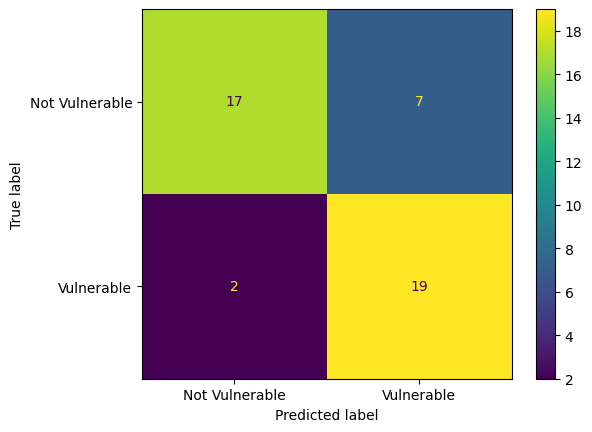

In [18]:
y_pred = get_predictions(knn_few_shot_fix_results)
metrics['KNN Few-shot Fix'] = get_and_display_metrics(y_true, y_pred)

## Results

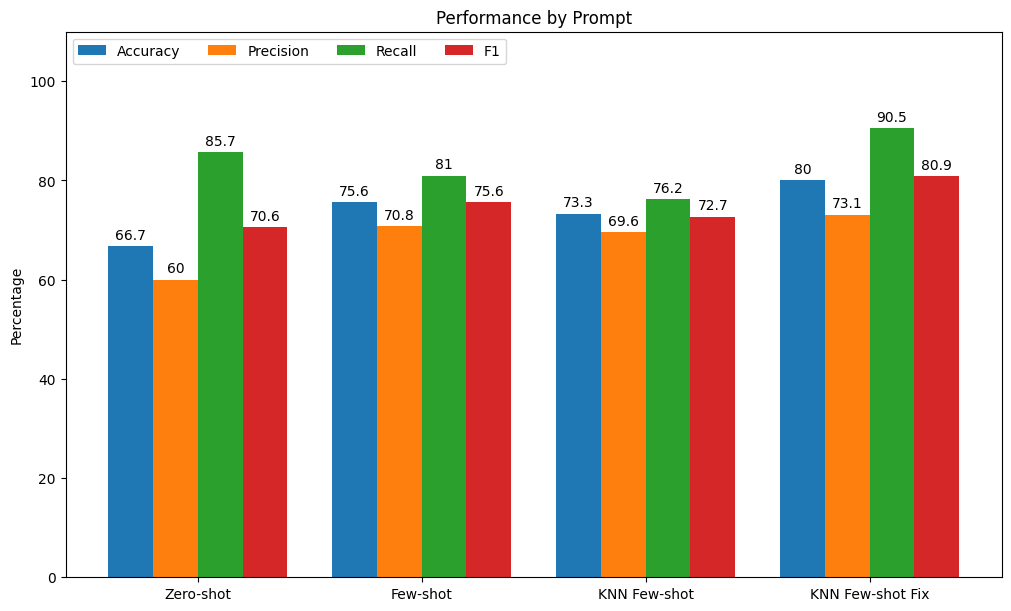

In [20]:
def make_chart(metrics):
    """Print a bar chart from a metrics dictionary."""
    prompt_types = metrics.keys()
    display_metrics = {
        'Accuracy': [round(100*metrics[k]['Accuracy'], 1) for k in prompt_types],
        'Precision': [round(100*metrics[k]['Precision'], 1) for k in prompt_types],
        'Recall': [round(100*metrics[k]['Recall'], 1) for k in prompt_types],
        'F1': [round(100*metrics[k]['F1'], 1) for k in prompt_types],
    }

    x = np.arange(len(prompt_types))  # the label locations
    width = 0.2  # the width of the bars
    multiplier = -0.5

    fig, ax = plt.subplots(layout='constrained', figsize=(10, 6))

    for attribute, measurement in display_metrics.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add labels, title, custom x-axis tick labels, and legend
    ax.set_ylabel('Percentage')
    ax.set_title('Performance by Prompt')
    ax.set_xticks(x + width, prompt_types)
    ax.legend(loc='upper left', ncols=4)
    
    plt.ylim((0, 110))
    plt.show()

make_chart(metrics)

## Citations

```
@misc{bakhshandeh2023using,
      title={Using ChatGPT as a Static Application Security Testing Tool}, 
      author={Atieh Bakhshandeh and Abdalsamad Keramatfar and Amir Norouzi and Mohammad Mahdi Chekidehkhoun},
      year={2023},
      eprint={2308.14434},
      archivePrefix={arXiv},
      primaryClass={cs.CR}
}

@misc{noever2023large,
      title={Can Large Language Models Find And Fix Vulnerable Software?}, 
      author={David Noever},
      year={2023},
      eprint={2308.10345},
      archivePrefix={arXiv},
      primaryClass={cs.SE}
}

@article{nori2023can,
  title={Can generalist foundation models outcompete special-purpose tuning? case study in medicine},
  author={Nori, Harsha and Lee, Yin Tat and Zhang, Sheng and Carignan, Dean and Edgar, Richard and Fusi, Nicolo and King, Nicholas and Larson, Jonathan and Li, Yuanzhi and Liu, Weishung and others},
  journal={arXiv preprint arXiv:2311.16452},
  year={2023}
}

@misc{pearce2021asleep,
      title={Asleep at the Keyboard? Assessing the Security of GitHub Copilot's Code Contributions}, 
      author={Hammond Pearce and Baleegh Ahmad and Benjamin Tan and Brendan Dolan-Gavitt and Ramesh Karri},
      year={2021},
      eprint={2108.09293},
      archivePrefix={arXiv},
      primaryClass={cs.CR}
}

@misc{pearce2022examining,
      title={Examining Zero-Shot Vulnerability Repair with Large Language Models}, 
      author={Hammond Pearce and Benjamin Tan and Baleegh Ahmad and Ramesh Karri and Brendan Dolan-Gavitt},
      year={2022},
      eprint={2112.02125},
      archivePrefix={arXiv},
      primaryClass={cs.CR}
}
```